# Assignment 3: Autonomous Driving (Part 2)

In this assignment, the goal is to use the training data from the assignment Autonomous Driving (Part 1) for learning to drive autonomously. For that reason, we will use the car racing example from [Gymnasium](https://gymnasium.farama.org). As showed in the last assignment, Gym is a framework for developing reinforcement learning approaches. It supports different types of agents. Here, we will focus on vehicles.

*Important*: You need to install [Gymnasium](https://gymnasium.farama.org) in your system. The installation can be done with pip or by installing from the sources. More information at [https://pypi.org/project/gymnasium/](https://pypi.org/project/gymnasium/)).

*Important*: The Python version of Gym and the Python version of PyTorch has to be the same. This is an important requirement for creating the inference pipeline function.

Note that all scripts should be self-contained and executed on *any* machine that has required libraries installed.

The solutions of the assignment can be delivered as Python Notebooks or .py files. The visual results shall be delivered as pdf- or image-files.



## 1. Car Racing Model Learning

In this exercise, a car drives on a track in a racing environment. The car can turn left, right, accelerate or decelerate. The input is an image with 96x96 pixels or 96x84, if you removed the black bar on the bottom of the image. In addition, rewards are given based on the driving behavior. We are not interested in the rewards in this task. The aim of this exercise is to make use of the training data from part 1 to train a deep neural network to control the vehicle. 

*Task Output*: The training set of 5000 car racing images should be split into 60% training, 20% validation and 20% test samples. All subsets should include consecutive frames. The 20% test samples should include a maneuver (accelerate, decelerate, go-right/left). The neural network architecture can be chosen based on the previous classification assignment on MNIST (CNN model). However, the output of the network should be a softmax with 5 classes (accelerate, decelerate, turn left, turn right, no actions). At this point, data augmentation should not be used during training. The output of the exercise should be a plot of the training, validation and test set loss over time and the accuracy over time. The model has to be trained with [early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) using _min_delta=0.0_ and _patience=3_.

*Important*: The scripts should be **self-contained**. The data augmentation should be dynamically implemented, i.e it is applied when the data from the mini-batch is loaded.

In [26]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import os
from PIL import Image

class CarRacingDataset(Dataset):
    def __init__(self, npz_file, transform=None, grayscale=False):
        # Load the npz file
        data = np.load(npz_file)
        self.images = data['frames']
        self.labels = data['controls'].astype(int)
        self.transform = transform
        self.grayscale = grayscale


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.grayscale:
            image = image.convert('L')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# Load dataset from npz file
dataset = CarRacingDataset(r'E:\MLSP\Lab\training_data.npz', transform=transform, grayscale=False)

# Split dataset
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [27]:
import torch.nn as nn
import torch.nn.functional as F

class CarRacingCNN(nn.Module):
    def __init__(self, input_channels):
        super(CarRacingCNN, self).__init__()
        self.input_channels = input_channels

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CarRacingCNN(input_channels=3)


In [2]:
"""import torch.nn as nn
import torch.nn.functional as F

class EnhancedCarRacingCNN(nn.Module):
    def __init__(self, input_channels):
        super(EnhancedCarRacingCNN, self).__init__()
        self.input_channels = input_channels

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 512 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = EnhancedCarRacingCNN(input_channels=3)
"""

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

# Example CNN model (assuming it is already defined)
# model = CarRacingCNN()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs,model_name):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [] ,[]

    best_val_loss = float('inf')
    patience, num_bad_epochs = 3, 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            #labels = labels.to(device).long()

            labels = torch.argmax(labels, dim=1).to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                #labels = labels.to(device).long()
                labels = torch.argmax(labels, dim=1).to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)


        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss - 0.0:  # min_delta=0.0
            best_val_loss = val_loss
            num_bad_epochs = 0
            torch.save(model.state_dict(), '{}.pt'.format(model_name))
        else:
            num_bad_epochs += 1

        if num_bad_epochs >= patience:
            print("Early stopping triggered")
            break

    #torch.save(model.state_dict(), 'best_model.pt')
 
    return train_losses, val_losses , train_accuracies, val_accuracies



In [ ]:
train_losses, val_losses , train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, model_name = 'best_model')


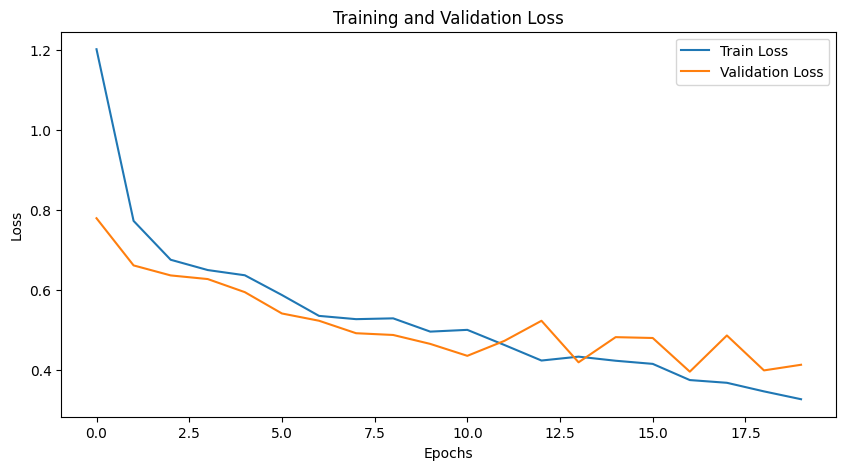

In [24]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


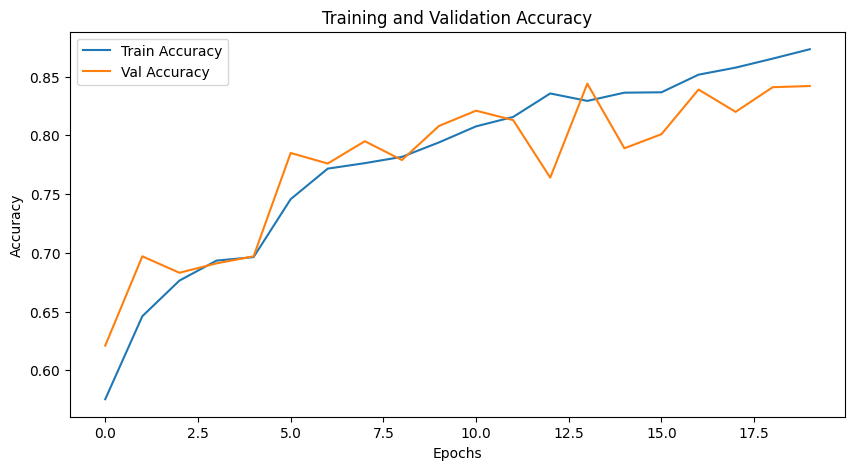

In [25]:
# Plot accuracies
plt.figure(figsize=(10,5))

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [26]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images= images.to(device) 
        labels = torch.argmax(labels, dim=1).to(device).long()

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.4087, Test Accuracy: 0.8350


## 2. Data Augmentation for Car Racing

This exercise is an extension of the previous one. Here, the deep neural network has to be trained with data augmentation. The same data split from part 1 will be applied here.

*Task Output*: Repeat the training process with data augmentation. Each augmentation should be applied with probability 20% inside the mini-batch loading. The augmentations that have to be implemented are horizontal flipping and random rotation (up to 20 degrees). The output of the exercise should be a plot of the training, validation and test set loss over time and the accuracy over time. The model has to be trained with early stopping using _min_delta=0.0_ and _patience=3_. Finally, the loss and accuracy of training with and without augmentation should be visualized in the same plot.

*Important*: The scripts should be **self-contained**. The data augmentation should be dynamically implemented, i.e it is applied when the data from the mini-batch is loaded.

In [39]:




# Define the dataset class with data augmentation
class CarRacingDatasetWithAugmentation(Dataset):
    def __init__(self, data, labels, transform=None, augmentation_prob=0.2):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.augmentation_prob = augmentation_prob

    def __len__(self):
        return len(self.data)
    
    

    def __getitem__(self, idx):
        image = Image.fromarray(self.data[idx])
        label = self.labels[idx]
        label = np.array(label)

        
        

        if self.transform is not None and np.random.rand() < self.augmentation_prob:
            
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            if (label == np.array([0, 0, 1, 0, 0])).all():
                label = [0,0,0,1,0]
            if (label == np.array([0, 0, 0, 1, 0])).all():
                label = [0,0,1,0,0]
            image = transforms.ToTensor()(image)
            label = torch.tensor(label, dtype=torch.long)
            
        
        #image = transforms.ToTensor()(image)
        #label = torch.tensor(label, dtype=torch.long)



        elif self.transform is not None and np.random.rand() < self.augmentation_prob:
            image = transforms.ToTensor()(image)
            label = torch.tensor(label, dtype=torch.long)
            image = self.transform(image)
        
        else :
            image = transforms.ToTensor()(image)
            label = torch.tensor(label, dtype=torch.long)

        return image, label

  

In [40]:
# Define data augmentation transforms
transform = transforms.Compose([
    
    transforms.RandomRotation(20),
    transforms.Resize((96, 96))

    
])


In [41]:
# Load the data
data = np.load(r'E:\MLSP\Lab\training_data2.npz')
images = data['frames']  # Shape: (N, 96, 96, 3)
labels = data['controls'].astype(int)  # Shape: (N, 5) - one-hot encoded





In [42]:
up, dn, left,right , nothing = 0,0,0,0,0
for i in labels:
    if np.array_equal(i , ([1,0,0,0,0])):
        up += 1
    if np.array_equal(i ,np.array([0,1,0,0,0])):
        dn += 1
    if np.array_equal(i ,np.array([0,0,1,0,0])):
        left += 1
    if np.array_equal(i ,([0,0,0,1,0])):
        right += 1
    if np.array_equal(i , np.array([0,0,0,0,1])):
        nothing += 1

print ('up = {}'.format(up))
print ('dn = {}'.format(dn))
print ('left = {}'.format(left))
print ('right = {}'.format(right))
print ('nothing = {}'.format(nothing))

up = 1200
dn = 700
left = 1200
right = 1200
nothing = 700


In [43]:
from sklearn.model_selection import train_test_split


# Split data
train_data, val_test_data, train_labels, val_test_labels = train_test_split(
    images, labels, test_size=0.4, random_state=42,  stratify=labels)
val_data, test_data, val_labels, test_labels = train_test_split(
    val_test_data, val_test_labels, test_size=0.5, random_state=42, stratify=val_test_labels)

In [45]:
# Create datasets with data augmentation
train_dataset = CarRacingDatasetWithAugmentation(train_data, train_labels, transform=transform)
val_dataset = CarRacingDatasetWithAugmentation(val_data, val_labels, transform=None)
test_dataset = CarRacingDatasetWithAugmentation(test_data, test_labels, transform=None)

In [46]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np



augmented_model = CarRacingCNN(input_channels=3)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
augmented_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(augmented_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

aug_train_losses, aug_val_losses , train_accuracies, val_accuracies = train_model(augmented_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, model_name = 'best_aug_model1')


e:\MLSP\Lab\virtual_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 94/94 [00:20<00:00,  4.59it/s]


Epoch 1/25, Train Loss: 0.8811, Val Loss: 0.5701


100%|██████████| 94/94 [00:25<00:00,  3.65it/s]


Epoch 2/25, Train Loss: 0.5784, Val Loss: 0.5053


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch 3/25, Train Loss: 0.4954, Val Loss: 0.4329


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch 4/25, Train Loss: 0.4549, Val Loss: 0.3611


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch 5/25, Train Loss: 0.4149, Val Loss: 0.3650


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch 6/25, Train Loss: 0.3810, Val Loss: 0.3066


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch 7/25, Train Loss: 0.3655, Val Loss: 0.3211


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch 8/25, Train Loss: 0.3214, Val Loss: 0.2591


100%|██████████| 94/94 [00:22<00:00,  4.21it/s]


Epoch 9/25, Train Loss: 0.2896, Val Loss: 0.2794


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch 10/25, Train Loss: 0.2773, Val Loss: 0.2414


100%|██████████| 94/94 [00:23<00:00,  4.04it/s]


Epoch 11/25, Train Loss: 0.2455, Val Loss: 0.2994


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch 12/25, Train Loss: 0.2691, Val Loss: 0.3535


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch 13/25, Train Loss: 0.2216, Val Loss: 0.2427
Early stopping triggered


In [13]:
# Plotting the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(aug_train_losses, label='Augmented Train Loss')
plt.plot(aug_val_losses, label='Augmented validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'plt' is not defined

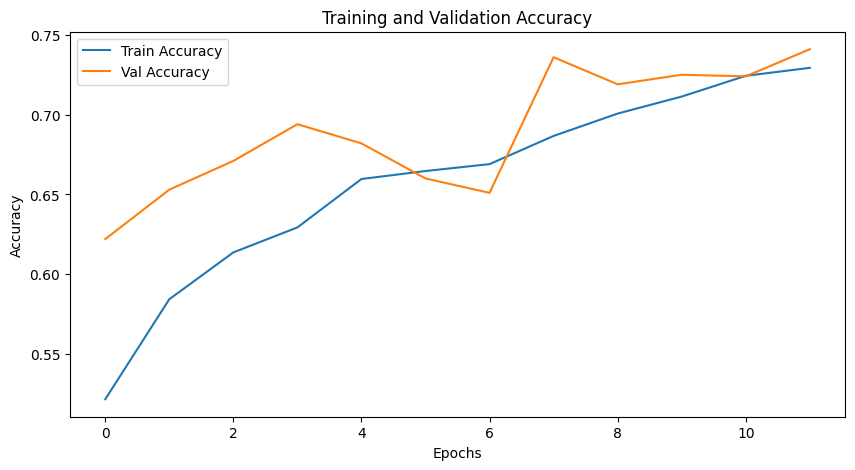

In [51]:
# Plot accuracies
plt.figure(figsize=(10,5))

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [48]:
augmented_model.load_state_dict(torch.load('best_aug_model1.pt'))
augmented_model.eval()

test_loss = 0.0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images= images.to(device) 
        labels = torch.argmax(labels, dim=1).to(device).long()

        outputs = augmented_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.2609, Test Accuracy: 0.9030


In [35]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print(f"CUDA is available! PyTorch version: {torch.__version__}")
        print(f"Number of GPUs available: {torch.cuda.device_count()}")
        print(f"GPU name: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA is not available. PyTorch will use the CPU.")

check_cuda()


CUDA is available! PyTorch version: 2.3.1+cu118
Number of GPUs available: 1
GPU name: NVIDIA GeForce GTX 1050


## 3. Mono-Color Training

In this task, the input images will be converted to gray-scale. Then the model will be trained on the new input data. The motivation of this exercise is to examine whether the color is necessary to train the model.

*Task Output*: Repeat the training process with gray-scale images instead of RGB data. For that purpose, the 5000 images have to be converted into gray-scale off-line or on-line when fetching a mini-batch. The training should be conducted without augmentation. The output of the exercise should be a plot of the training, validation and test set loss over time and the accuracy over time. The model has to be trained with early stopping using _min_delta=0.0_ and _patience=3_. Finally, the loss and accuracy of training with RGB and gray-scale images should be visualized in the same plot.

*Important*: The scripts should be **self-contained**. The data augmentation should be dynamically implemented, i.e it is applied when the mini-batch is loaded.

In [35]:
transform_gray = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale
])

In [36]:
# Load dataset from npz file
dataset_gray = CarRacingDataset(r'E:\MLSP\Lab\training_data.npz', transform=transform_gray, grayscale=False)

# Split dataset
train_size = int(0.6 * len(dataset_gray))
val_size = int(0.2 * len(dataset_gray))
test_size = len(dataset_gray) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_gray, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
'''image, label = dataset_gray[100]
image
plt.imshow(image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

print (type(image))'''

"image, label = dataset_gray[100]\nimage\nplt.imshow(image, cmap='gray')\nplt.title('Grayscale Image')\nplt.axis('off')\nplt.show()\n\nprint (type(image))"

In [32]:

len(dataset_gray)

5000

In [37]:
model_gray = CarRacingCNN(input_channels=1)

In [38]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

train_losses_gray, val_losses_gray , train_accuracies_gray, val_accuracies_gray = train_model(model_gray, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, model_name = 'best_model_gray')


e:\MLSP\Lab\venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 94/94 [01:52<00:00,  1.20s/it]


Epoch 1/25, Train Loss: 1.6179, Val Loss: 1.6184


100%|██████████| 94/94 [01:54<00:00,  1.22s/it]


Epoch 2/25, Train Loss: 1.6178, Val Loss: 1.6185


100%|██████████| 94/94 [01:54<00:00,  1.22s/it]


Epoch 3/25, Train Loss: 1.6179, Val Loss: 1.6182


100%|██████████| 94/94 [01:55<00:00,  1.23s/it]


Epoch 4/25, Train Loss: 1.6179, Val Loss: 1.6185


100%|██████████| 94/94 [01:56<00:00,  1.24s/it]


Epoch 5/25, Train Loss: 1.6178, Val Loss: 1.6183


100%|██████████| 94/94 [02:00<00:00,  1.28s/it]


Epoch 6/25, Train Loss: 1.6179, Val Loss: 1.6183
Early stopping triggered


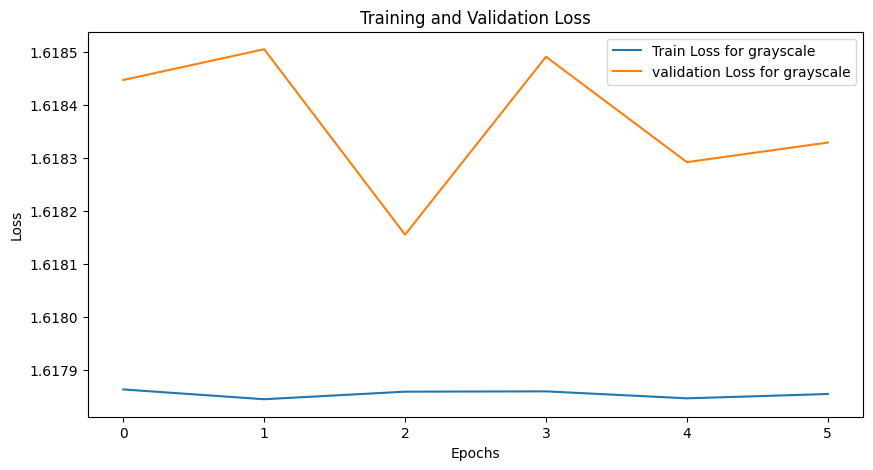

In [39]:
# Plotting the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses_gray, label='Train Loss for grayscale')
plt.plot(val_losses_gray, label='validation Loss for grayscale')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

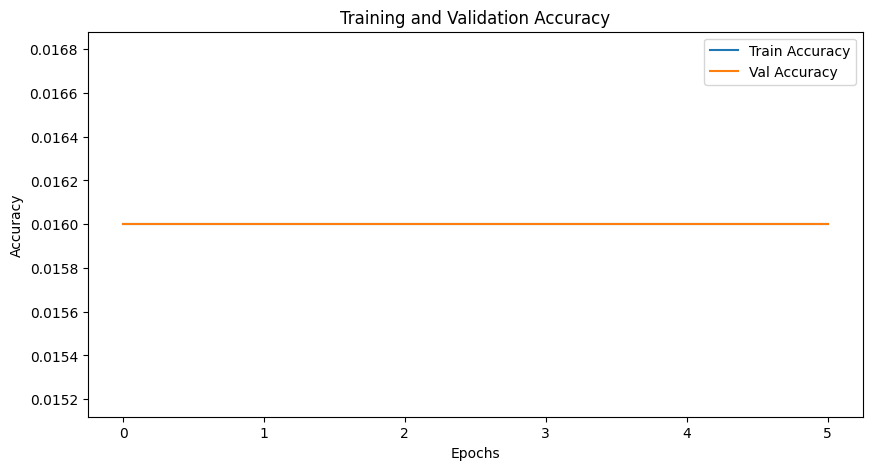

In [40]:
# Plot accuracies
plt.figure(figsize=(10,5))

plt.plot(train_accuracies_gray, label='Train Accuracy')
plt.plot(val_accuracies_gray, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


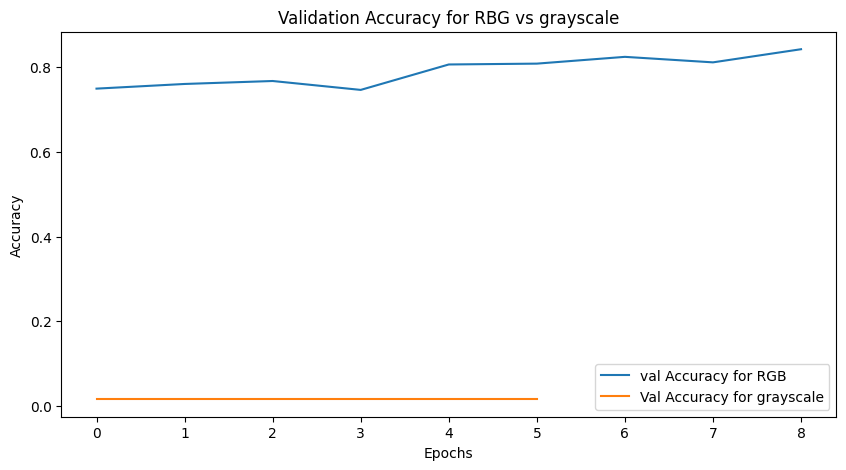

In [41]:
# Plot accuracies
plt.figure(figsize=(10,5))

plt.plot(val_accuracies, label='val Accuracy for RGB')
plt.plot(val_accuracies_gray, label='Val Accuracy for grayscale')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for RBG vs grayscale')

plt.show()
